In [1]:
import numpy as np
from mnist_tasks.generate_color_mnist import *
from mnist_tasks.mnist_loader import trainloader, testloader, valloader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as T
import os
import pandas as pd
    
transform = {
    "background": transform_digit_color,
    "full": transform_image
}
random_generator = {
    "background": generate_random_digit_color,
    "full": generate_random_environment
}
#change the const below to change generator
MODE = "background"

#digits to store
digits_to_store = [0, 1]

store_dir = "/hdd2/dyah/coloredmnist_synthetic"
if not os.path.isdir(store_dir):
    os.makedirs(store_dir)

Compose(
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
Train data set: 54000
Test data set: 10000
Valid data set: 6000


## Changing environment generation mode
"background" mode is just changing the background color, digit color will stay white <br>
"full" is changing both digit and background color <br>
change the constant in "MODE"

In [9]:
def transform_image_with_env(env, loader):
    images = torch.zeros((1,3,28,28))
    y_true = []
    for batch_idx, (imgs, labels) in tqdm(enumerate(loader)):
        if len(digits_to_store) > 0:
            mask = np.logical_or(labels == digits_to_store[0], labels == digits_to_store[1])
            imgs = imgs[mask,:,:,:]
            labels = labels[mask]
        transformed_imgs = transform[MODE](imgs, labels,env)
        images=torch.vstack((images,transformed_imgs))
        y_true.extend(labels.detach().cpu().numpy())
    images = images[1:,:,:,:]
    y_true = torch.Tensor(y_true)
    return images, y_true

In [3]:
def generate_random_flip_map(digits=digits_to_store):
    if len(digits) == 0:
        digits = np.arange(10)
    random_shuffle = np.copy(digits)
    np.random.shuffle(random_shuffle)
    random_mapping = {}
    for idx, digit in enumerate(digits):
        random_mapping[digit] = random_shuffle[idx]
    return random_mapping

In [4]:
def flip_digit_color(flip_mapping, env):
    new_mapping = {}
    for key in flip_mapping:
        new_mapping[key] = env[flip_mapping[key]]
        new_mapping[flip_mapping[key]] = env[key]
    return new_mapping

In [5]:
def show_random_images(images):
    random_samples = np.random.choice(np.linspace(0, images.shape[0]-1, images.shape[0], dtype=int), 10)
    random_samples = images[random_samples, :,:,:]
    nrows = 3
    fig, ax = plt.subplots(nrows, ncols=random_samples.shape[0]//nrows)
    i=0
    for row in ax:
        for col in row:
            image = random_samples[i,:,:,:]*255
            col.imshow(image.permute(1,2,0).detach().cpu().numpy().astype(np.uint8))
            i+=1
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

In [11]:
def save_images_and_get_metadata(images, labels, split, save_dir):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    image_id = 0
    transform = T.ToPILImage()
    metadata_df = {"image_path": [], "label": [], "split": []}
    labels = labels.detach().cpu().numpy()
    for img_idx in range(images.shape[0]):
        img_tensor = images[img_idx, :, :, :]
        img_tensor = torch.squeeze(img_tensor)
        image_id += 1
        img = transform(img_tensor)
        image_path = os.path.join(save_dir, f"img_{image_id}_{split}.png")
        img.save(image_path)
        metadata_df["image_path"].append(image_path)
        metadata_df["label"].append(int(labels[img_idx]))
        metadata_df["split"].append(split)
    return metadata_df

In [7]:
env_1 = random_generator[MODE](digits_to_store)
env_1

{0: array([0.4627451 , 0.29803922, 0.61176471]),
 1: array([0.70980392, 0.49411765, 0.42352941])}

In [10]:
img_env_1_train, env_1_labels_train = transform_image_with_env(env_1, trainloader)

0it [00:00, ?it/s]/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  import sys
/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  
422it [03:13,  2.18it/s]


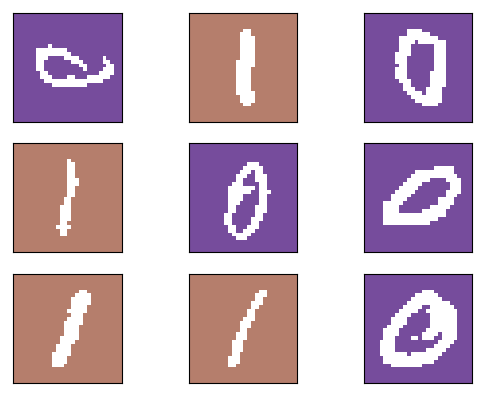

In [12]:
show_random_images(img_env_1_train)

In [13]:
train_metadata = save_images_and_get_metadata(img_env_1_train, env_1_labels_train, 0, save_dir=os.path.join(store_dir, "env_1"))

In [14]:
img_env_1_test, env_1_labels_test = transform_image_with_env(env_1, testloader)
test_metadata = save_images_and_get_metadata(img_env_1_test, env_1_labels_test, 1, save_dir=os.path.join(store_dir, "env_1"))
img_env_1_val, env_1_labels_val = transform_image_with_env(env_1, valloader)
val_metadata = save_images_and_get_metadata(img_env_1_val, env_1_labels_val, 2, save_dir=os.path.join(store_dir, "env_1"))

0it [00:00, ?it/s]/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  import sys
/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  
79it [00:35,  2.24it/s]
47it [00:20,  2.24it/s]


In [15]:
def merge_metadata(train_metadata, test_metadata, val_metadata):
    image_path = [path for path in train_metadata['image_path']]
    image_path.extend([path for path in test_metadata['image_path']])
    image_path.extend([path for path in val_metadata['image_path']])
    metadata_all = {'image_path': image_path}
    
    labels = [label for label in train_metadata['label']]
    labels.extend([label for label in test_metadata['label']])
    labels.extend([label for label in val_metadata['label']])
    metadata_all['label'] = labels
    
    splits = [split for split in train_metadata['split']]
    splits.extend([split for split in test_metadata['split']])
    splits.extend([split for split in val_metadata['split']])
    metadata_all['split'] = splits
    return metadata_all

In [16]:
def store_metadata(df, save_dir):
    df = pd.DataFrame(df)
    df.to_csv(os.path.join(save_dir,"metadata.csv"))

In [17]:
metadata_all = merge_metadata(train_metadata, test_metadata, val_metadata)

In [18]:
store_metadata(metadata_all, save_dir=os.path.join(store_dir, "env_1"))

In [19]:
flip_map = generate_random_flip_map()
flip_map

{0: 1, 1: 0}

In [20]:
env_1_flip = flip_digit_color(flip_map, env_1)
env_1_flip

{0: array([0.70980392, 0.49411765, 0.42352941]),
 1: array([0.4627451 , 0.29803922, 0.61176471])}

0it [00:00, ?it/s]/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  import sys
/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  
422it [03:13,  2.18it/s]


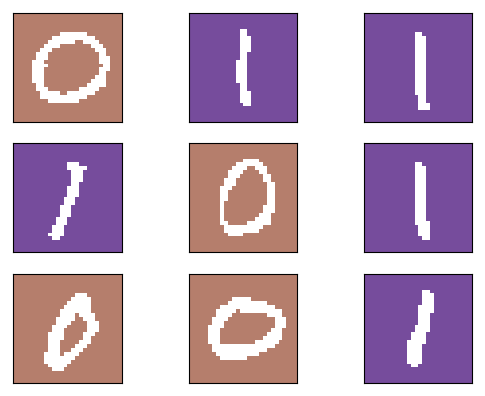

In [21]:
img_env_1_train_flip, env_1_labels_train_flip = transform_image_with_env(env_1_flip, trainloader)
show_random_images(img_env_1_train_flip)

In [ ]:
train_metadata = save_images_and_get_metadata(img_env_1_train_flip, env_1_labels_train_flip, 0, save_dir=os.path.join(store_dir, "env_1_FLIP"))

img_env_1_test_flip, env_1_labels_test_flip = transform_image_with_env(env_1_flip, testloader)
test_metadata = save_images_and_get_metadata(img_env_1_test_flip, env_1_labels_test_flip, 1, save_dir=os.path.join(store_dir, "env_1_FLIP"))

img_env_1_val_flip, env_1_labels_val_flip = transform_image_with_env(env_1_flip, valloader)
val_metadata = save_images_and_get_metadata(img_env_1_val_flip, env_1_labels_val_flip, 1, save_dir=os.path.join(store_dir, "env_1_FLIP"))

0it [00:00, ?it/s]/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  import sys
/hdd2/dyah/anaconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  
3it [00:01,  1.85it/s]

In [ ]:
metadata_all = merge_metadata(train_metadata, test_metadata, val_metadata)
store_metadata(metadata_all, save_dir=os.path.join(store_dir, "env_1_FLIP"))